# Imbalanced Learning

### Artículo completo en www.aprendemachinelearning.com

Disponemos de varias estrategias:

- **Ajuste de Parámetros del modelo:** Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro class_weight= “balanced” que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.

- **Modificar el Dataset:** podemos eliminar muestras de la clase mayoritaria para reducirlo e intentar equilibrar la situación. Tiene como “peligroso” que podemos prescindir de muestras importantes, que brindan información y por lo tanto empeorar el modelo. Entonces para seleccionar qué muestras eliminar, deberíamos seguir algún criterio. También podríamos agregar nuevas filas con los mismos valores de las clases minoritarias, por ejemplo cuadriplicar nuestras 492 filas. Pero esto no sirve demasiado y podemos llevar al modelo a caer en overfitting.

- **Muestras artificiales:** podemos intentar crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario. Según el método, podemos mejorar los resultados. Lo peligroso de crear muestras sintéticas es que podemos alterar la distribución “natural” de esa clase y confundir al modelo en su clasificación.

- **Balanced Ensemble Methods:** Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.


## Manejo de clases desbalanceadas con la librería Python ImbLearn

No olvides instalar con:<p> pip install -U imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline



## Dataset Credit Card Fraud Detection

Descarga de Kaggle en https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [2]:
df = pd.read_csv("creditcard.csv") # read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly4

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

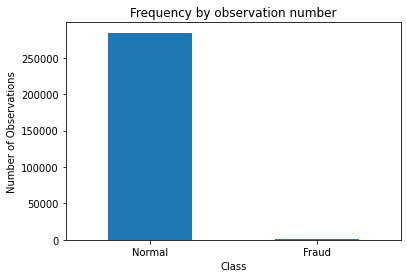

In [6]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [7]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

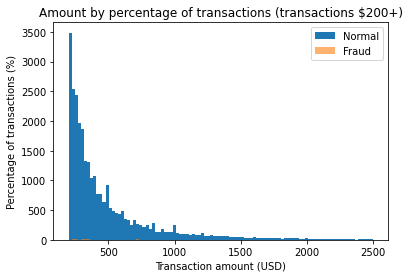

In [8]:
import matplotlib.pyplot as plt

#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

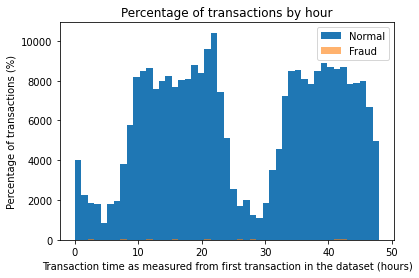

In [9]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

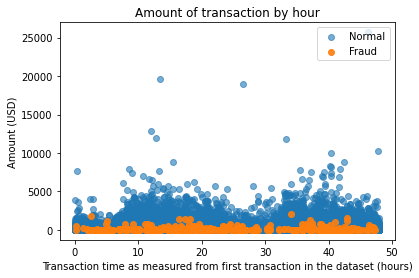

In [10]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [11]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of observations per class')

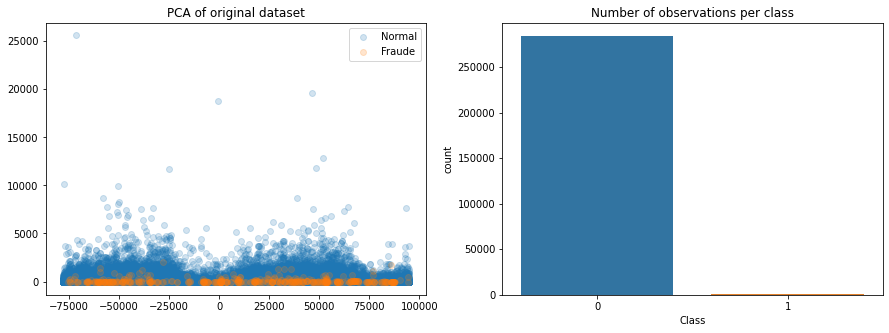

In [12]:
# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Fraude", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

In [13]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Modelo sin balancear

En este caso, desplegamos el modelo "tal cual", sin ningún tipo de ajuste. Vamos a ver qué pasa entrenando el modelo y obteniendo las predicciones.

In [14]:
model = run_model(X_train, X_test, y_train, y_test)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\Anaconda3\envs\environment2\lib\site-packages\sklearn\

In [15]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

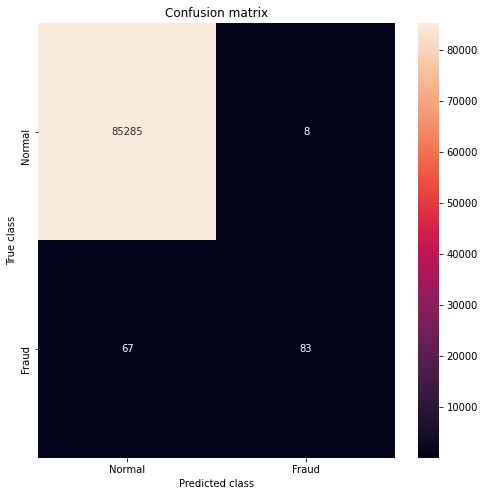

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.91      0.55      0.69       150

    accuracy                           1.00     85443
   macro avg       0.96      0.78      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [16]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Aqui vemos la matriz de confusión y en la clase 2 (es lo que nos interesa detectar) vemos 67 fallos y 83 aciertos dando un recall de 0.55 y es el valor que queremos mejorar. También es interesante notar que en la columna de f1-score obtenemos muy buenos resultados PERO que realmente no nos deben engañar… pues están reflejando una realidad parcial. **Lo cierto es que nuestro modelo no es capaz de detectar correctamente los casos de Fraude.**

# 1 Estrategia: Penalización

Ajuste de Parámetros del modelo: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro **class_weight= “balanced”** que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias. En XGBoost, lo veremos con otro ejemplo... utilizaremos **scale_pos_weight**

- **Revisar: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/**

In [17]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\op

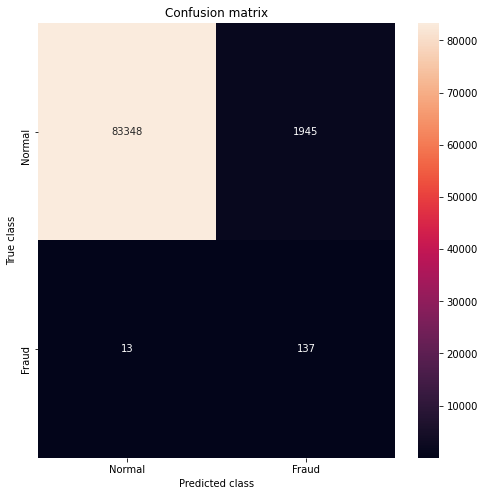

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85293
           1       0.07      0.91      0.12       150

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [18]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Ahora vemos una NOTABLE MEJORA! en la clase 2 -que indica si hubo fraude-, se han acertado 137 muestras y fallado en 13, dando un recall de 0.91 !! y sólo con agregar un parámetro al modelo 😉 También notemos que en la columna de f1-score parecería que hubieran “empeorado” los resultados… cuando realmente estamos mejorando la detección de casos fraudulentos. Es cierto que aumentan los Falsos Positivos y se han etiquetado 1945 muestras como Fraudulentas cuando no lo eran… pero pensad… **¿qué prefiere la compañía bancaria? ¿tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?**

# 2 NearMiss subsampling del grupo mayoritario

Lo que haremos es utilizar un algoritmo para reducir la clase mayoritaria. Lo haremos usando un algoritmo que hace similar al k-nearest neighbor para ir seleccionando cuales eliminar. Fijémonos que reducimos bestialmente de 199.020 muestras de clase cero (la mayoría) y pasan a ser 688. y Con esas muestras entrenamos el modelo.

In [19]:
us = NearMiss(sampling_strategy=0.5, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199022, 1: 342})
Distribution of class labels after resampling Counter({0: 684, 1: 342})


In [20]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\Anaconda3\envs\environment2\lib\site-packages\sklearn\

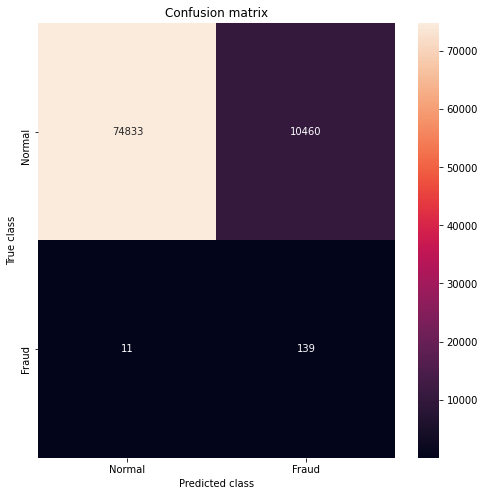

              precision    recall  f1-score   support

           0       1.00      0.88      0.93     85293
           1       0.01      0.93      0.03       150

    accuracy                           0.88     85443
   macro avg       0.51      0.90      0.48     85443
weighted avg       1.00      0.88      0.93     85443



In [21]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

También vemos que obtenemos muy buen resultado con recall de 0.93 aunque a costa de que aumentaran los falsos positivos.

# 3 Random Oversampling

En este caso, crearemos muestras nuevas “sintéticas” de la clase minoritaria. Usando RandomOverSampler. Y vemos que pasamos de 344 muestras de fraudes a 99511 (sampling_strategy = 50% de las muestras).

In [26]:
sampling_strategy = 0.8

os =  RandomOverSampler(sampling_strategy = 0.5)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199022, 1: 342})
Distribution of class labels after resampling Counter({0: 199022, 1: 99511})


In [27]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\Anaconda3\envs\environment2\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


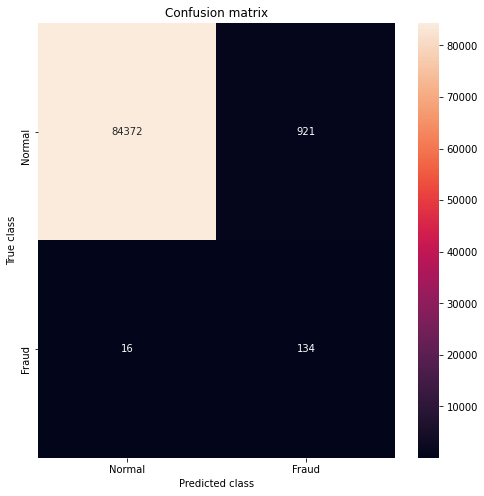

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85293
           1       0.13      0.89      0.22       150

    accuracy                           0.99     85443
   macro avg       0.56      0.94      0.61     85443
weighted avg       1.00      0.99      0.99     85443



In [28]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Tenemos un 0.89 de recall para la clase 2 y los Falsos positivos son 921. Nada mal.

# 4 Combinando Smote tomek

Ahora probaremos una técnica muy usada que consiste en **aplicar de forma simultánea** un algoritmo de subsampling y otro de oversampling a la vez al dataset. En este caso usaremos SMOTE para oversampling: busca puntos vecinos cercanos y agrega puntos “en linea recta” entre ellos. Y usaremos Tomek para undersampling que quita los de distinta clase que sean nearest neighbor y deja ver mejor el decisión boundary (la zona limítrofe de nuestras clases).

In [31]:
sampling_strategy = 0.2
os_us = SMOTETomek(sampling_strategy = 0.2)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 199022, 1: 342})
Distribution of class labels after resampling Counter({0: 198114, 1: 38896})


In [32]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\feeadmin\Anaconda3\envs\environment2\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


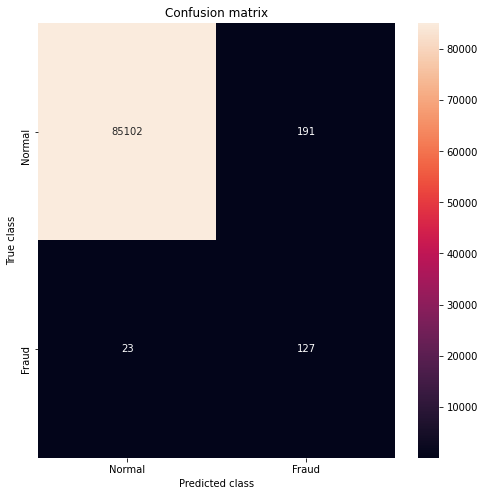

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.40      0.85      0.54       150

    accuracy                           1.00     85443
   macro avg       0.70      0.92      0.77     85443
weighted avg       1.00      1.00      1.00     85443



In [33]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

En este caso seguimos teniendo bastante buen recall 0.85 de la clase 2 y vemos que los Falsos positivos de la clase 1 son bastante pocos, 191 (de 38896 muestras).

# 5 Ensemble balanceado

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging, la variable base_estimator por defecto es None y el modelo será un DecisionTree. Veamos como se comporta:

In [40]:
from sklearn.datasets import make_classification

#Create an object of the classifier.

X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, 
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
bbc = BalancedBaggingClassifier()

#Train the classifier.
bbc.fit(X_train, y_train)

AttributeError: 'BalancedBaggingClassifier' object has no attribute 'n_features_in_'

In [ ]:
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Resultados

In [ ]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística', 'Penalizacion', 'NearMiss Subsampling', 
                                  'Random Oversampling', 'Smote Tomek', 'Ensemble'],
                   'precision' : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                   'recall' : [0.66, 0.93, 0.93, 0.89, 0.85, 0.88]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

df = df.sort_values(['overall'], ascending=False)
df